# Psychometric function 

In [127]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from scipy.optimize import curve_fit, minimize

In [128]:
N_r = 3
experiments = 30
I_s = np.array([5, 10, 15, 20, 25, 30])
N_yes = np.array([12, 11, 19, 27, 30, 30])
P_guess = 1/N_r

In [129]:
def psy_log_likelihood(params, I, k, N):
    c, sigma_I = params

    TP = norm.cdf((I - c) / sigma_I)
    TP = np.clip(TP, 1e-10, 1 - 1e-10)

    log_likelihood = np.sum(k * np.log(TP) + (N - k) * np.log(1 - TP))
    
    return -log_likelihood

In [130]:
def ht_log_likelihood(params, I, k, N, P_guess):
    c, sigma_I = params

    v = (1-P_guess) * norm.cdf((I - c) / sigma_I) + P_guess
    v = np.clip(v, 1e-10, 1 - 1e-10)

    log_likelihood = np.sum(k * np.log(v) + (N - k) * np.log(1 - v))
    
    return -log_likelihood


In [131]:
def lapse_log_likelihood(params, I, k, N, P_guess):
    c, sigma_I, P_lapse = params  # Unpack the parameters (threshold and standard deviation)

    v = (1 - P_guess - P_lapse) * norm.cdf((I - c) / sigma_I) + P_guess

    v = np.clip(v, 1e-10, 1 - 1e-10)
    
    # Binomial log-likelihood
    log_likelihood = np.sum(k * np.log(v) + (N - k) * np.log(1 - v))

    return -log_likelihood 


In [132]:
def psyfunctions(I_s, N_yes, experiments):
    # Initial guesses for c and sigma_I 
    initial_params = [10.0, 10.0]

    # Optimize to find the best-fitting 
    result_psy = minimize(psy_log_likelihood, initial_params, args=(I_s, N_yes, experiments))

    # Initial guesses for c and sigma_I 
    initial_params = [10.0, 10.0]

    # Optimize to find the best-fitting 
    result_ht = minimize(ht_log_likelihood, initial_params, args=(I_s, N_yes, experiments, P_guess))

    
    # Initial guesses for c and sigma_I 
    initial_params = [10.0, 10.0, 0.05] 
    # Set bounds for the optimization to prevent sigma_I from being zero
    bounds_lapse = [(None, None), (1e-3, None), (0, 1)]  # Bounds for [c, sigma_I, P_lapse]


    # Optimize to find the best-fitting 
    result_lapse = minimize(lapse_log_likelihood, initial_params, args=(I_s, N_yes, experiments, P_guess), bounds=bounds_lapse)

    return result_psy, result_ht, result_lapse

In [133]:
def ps_plot(I_s, result_psy, result_ht, result_lapse, P_guess):
    c_psy_est, sigma_psy_est = result_psy.x
    c_ht_est, sigma_ht_est = result_ht.x
    c_lapse_est, sigma_lapse_est, P_lapse_est = result_lapse.x

    Ps_psy = []
    Ps_ht = []
    Ps_lapse = []
    for i in range(len(I_s)):
        P_psy = norm.cdf((I_s[i]-c_psy_est)/sigma_psy_est)
        P_htpsy = (1-P_guess) * norm.cdf((I_s[i]-c_ht_est) / sigma_ht_est) +P_guess
        P_lapse = (1 - P_guess - P_lapse_est) * norm.cdf((I_s[i]-c_lapse_est) / sigma_lapse_est) + P_guess
        Ps_psy.append(P_psy)
        Ps_ht.append(P_htpsy)
        Ps_lapse.append(P_lapse)


    plt.plot(I_s, Ps_psy,  alpha=0.6, label='Psychometric function')
    plt.plot(I_s, Ps_ht, label= 'High threshold psychometric function')
    plt.plot(I_s, Ps_lapse, label = 'Psychometric function with lapsing')
    plt.xlabel('Stimulus intensity, I')
    plt.ylabel('Ψ (I)')
    plt.legend()
    plt.show()

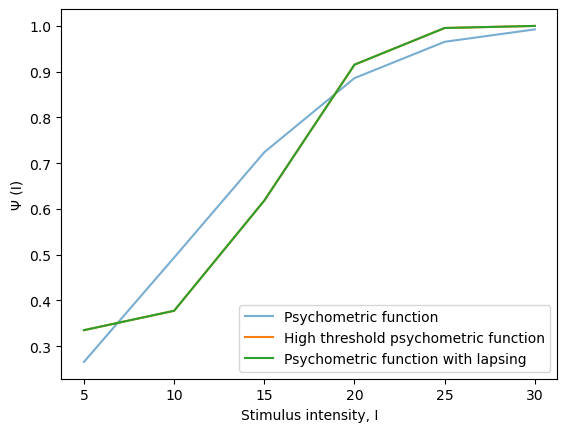

In [134]:
result_psy, result_ht, result_lapse = psyfunctions(I_s, N_yes, experiments)
ps_plot(I_s, result_psy, result_ht, result_lapse, P_guess)

### AIC
The Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data. AIC is calculated from:

* the number of independent variables used to build the model.
* the maximum likelihood estimate of the model (how well the model reproduces the data).

(The default K is always 2, so if your model uses one independent variable your K will be 3, if it uses two independent variables your K will be 4, and so on. If a model is more than 2 AIC units lower than another, then it is considered significantly better than that model.)

In [135]:
def parameter(result_psy, result_ht, result_lapse):

    c_psy_est, sigma_psy_est = result_psy.x
    psy_likelihood = result_psy.fun
    c_ht_est, sigma_ht_est = result_ht.x
    ht_likelihood = result_ht.fun
    c_lapse_est, sigma_lapse_est, P_lapse_est = result_lapse.x
    lapse_likelihood = result_lapse.fun

    print(f"The negative log likelihood: PSY: {psy_likelihood:.2f} High threshold: {ht_likelihood:.2f} Lapse: {lapse_likelihood:.2f}")

    best_nll = min(psy_likelihood, ht_likelihood, lapse_likelihood)
    if best_nll == psy_likelihood:
        print("PSY has the best fit based on Negative Log Likelihood.")
    elif best_nll == ht_likelihood:
        print("High threshold has the best fit based on Negative Log Likelihood.")
    else:
        print("Lapse has the best fit based on Negative Log Likelihood.")
    
    K_default = 2
    AIC_psy = 2*((K_default+len(result_psy.x))+psy_likelihood)
    AIC_ht = 2*((K_default+len(result_ht.x))+ht_likelihood)
    AIC_lapse = 2*((K_default+len(result_lapse.x))+lapse_likelihood)
    print(f"AIC: PSY: {AIC_psy:.2f} High threshold: {AIC_ht:.2f} Lapse: {AIC_lapse:.2f}")
    best_AIC = min(AIC_psy, AIC_ht, AIC_lapse)
    if best_AIC == AIC_psy:
        print("PSY has the best fit based on AIC.")
    elif best_AIC == AIC_ht:
        print("High threshold has the best fit based on AIC.")
    else:
        print("Lapse has the best fit based on AIC.")
    
    print(f"Parameters for PSY:\t\t c1 (threshold): {c_psy_est:.2f}, sigma_I (signal variability): {sigma_psy_est:.2f}")
    print(f"Parameters for High threshold:\t c1 (threshold): {c_ht_est:.2f}, sigma_I (signal variability): {sigma_ht_est:.2f}")
    print(f"Parameters for Lapse:\t\t c1 (threshold): {c_lapse_est:.2f}, sigma_I (signal variability): {sigma_lapse_est:.2f}, P_lapse (lapse probability): {P_lapse_est:.2f}")


In [136]:
parameter(result_psy, result_ht, result_lapse)

The negative log likelihood: PSY: 73.53 High threshold: 69.85 Lapse: 69.85
High threshold has the best fit based on Negative Log Likelihood.
AIC: PSY: 155.06 High threshold: 147.71 Lapse: 149.71
High threshold has the best fit based on AIC.
Parameters for PSY:		 c1 (threshold): 10.13, sigma_I (signal variability): 8.19
Parameters for High threshold:	 c1 (threshold): 15.69, sigma_I (signal variability): 3.78
Parameters for Lapse:		 c1 (threshold): 15.69, sigma_I (signal variability): 3.78, P_lapse (lapse probability): 0.00


### Lapse once at the highest stimulus intensity level

The negative log likelihood: PSY: 78.03 High threshold: 76.82 Lapse: 74.87
Lapse has the best fit based on Negative Log Likelihood.
AIC: PSY: 164.06 High threshold: 161.65 Lapse: 159.74
Lapse has the best fit based on AIC.
Parameters for PSY:		 c1 (threshold): 10.09, sigma_I (signal variability): 9.19
Parameters for High threshold:	 c1 (threshold): 15.48, sigma_I (signal variability): 5.79
Parameters for Lapse:		 c1 (threshold): 15.50, sigma_I (signal variability): 3.64, P_lapse (lapse probability): 0.02


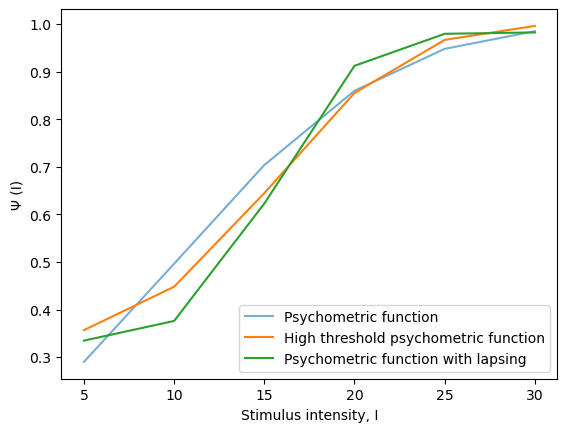

In [137]:
N_yes_prime =np.array([12, 11, 19, 27, 30, 29])

result_psy, result_ht, result_lapse = psyfunctions(I_s, N_yes_prime, experiments)

parameter(result_psy, result_ht, result_lapse)
ps_plot(I_s, result_psy, result_ht, result_lapse, P_guess)

Both Negative log likelihood and AIC increase. And in the previous, lapsing is the same as high threshold(since the P_lapsing = 0). But after the change, P_lapsing has value so the function looks different. So it does affect the analysis result

### synthetic faces

In [170]:
Is_face = [1, 2, 3, 4, 5, 6, 7, 8, 9]
directory_path = Path('data/generated_rating')
merged_df = pd.DataFrame()
for file in directory_path.rglob('*.csv'):
    data = pd.read_csv(file)
    merged_df = pd.concat([merged_df, data], ignore_index=True)
    
merged_df['Category'] = merged_df['Rating'].apply(lambda x: 'No' if x <= 6 else 'Yes')
rating_counts = merged_df.groupby(['ImageName', 'Category']).size().unstack(fill_value=0)
print(rating_counts)

Is_face = [1, 2, 3, 4, 5, 6, 7, 8, 9]
N_yes_face = rating_counts['Yes'].values
experiments = 30
N_r = 2
P_guess = 1/N_r

Category   No  Yes
ImageName         
0.jpg      30    0
1.jpg      30    0
2.jpg      30    0
3.jpg      29    1
4.jpg      25    5
5.jpg       7   23
6.jpg       6   24
7.jpg       1   29
8.jpg       0   30


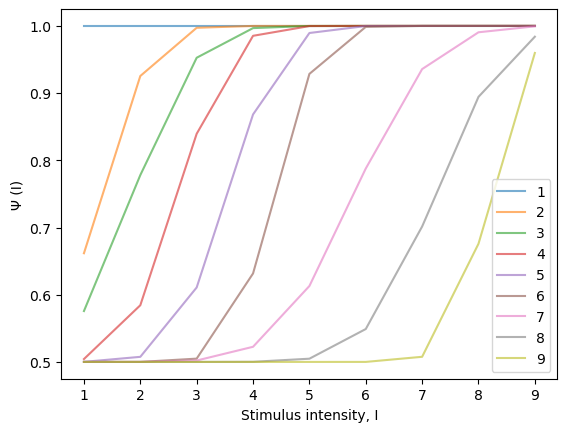

All the sigma values: ['0.01', '0.67', '0.85', '0.70', '0.71', '0.59', '1.06', '0.95', '0.56']
All the threshold values: ['-11.58', '1.31', '1.88', '2.67', '3.55', '4.37', '5.80', '7.23', '8.21']


In [213]:
Is_face = [1, 2, 3, 4, 5, 6, 7, 8, 9]

pairs = []
results = []
for c in Is_face:
    data['Binary'] = np.where(data['Rating'] >= c, 1, 0)
    binary_counts = data.groupby(['ImageName', 'Binary']).size().unstack(fill_value=0)
    N_yes_face = np.array(binary_counts.get(1).values)

    result_psy, result_ht, result_lapse = psyfunctions(Is_face, N_yes_face, experiments)
    #ps_plot(Is_face, result_psy, result_ht, result_lapse, P_guess)

    results.append(result_psy)

for id, psy in enumerate(results):
    c_est, sigma_est = psy.x
    Ps_htpsy = []
    
    for i in range(len(Is_face)):
        P_htpsy = (1-P_guess) * norm.cdf((Is_face[i]-c_est) / sigma_est) + P_guess
        Ps_htpsy.append(P_htpsy)
    plt.plot(Is_face, Ps_htpsy,  alpha=0.6, label=Is_face[id])
        
plt.xlabel('Stimulus intensity, I')
plt.ylabel('Ψ (I)')
plt.legend()
plt.show()
#     pairs.append(f"Pair: {image1} & {image2}")
# print([f"{s}" for s in pairs])
print("All the sigma values:", [f"{s.x[1]:.2f}" for s in results])
print("All the threshold values:", [f"{s.x[0]:.2f}" for s in results])

***The psychometric functions should all have the same (or similar) value for the σI parameter. Why?*** \
The face is generated from the linear line so the underlying sensitivity of the observer to them should be the same across different criteria. \
\
***The psychometric functions should be shifted along the x-axis. Why?*** \
Because the stimulus intensity is changing in different pairs and the threshold in different pairs is different, therefore, it should shift. \
\
***Compare your results to the equal variance signal detection exercise in Section2.2.3.*** \
Both of them have a weird value between 5 & 6. Maybe because it's hard for observer to distinguish.

# Magnitude estimation

In [110]:
def Fechner(Is,kw, I0):
    return (1/kw)*np.log(Is/I0)

In [111]:
Is = np.arange(1,11)

In [124]:
def fit_Fechner(Is, a):

    # Steve
    Ip = 10*Is**(a)


    initial_params = [1,1]
    bounds = ([1e-3, 1e-3], [np.inf, np.inf])  # kw and I0 must be positive

    params, _ = curve_fit(Fechner, Is, Ip, p0=initial_params, bounds=bounds)
    I_Fechner = Fechner(Is, params[0], params[1])

    print(f"Parameter values for Fechner’s: Ks: {params[0]:.5f}, I0: {params[1]:.5f}")
    
    plt.plot(Is, Ip, 'o-', label=f"Stevens' Law: $10 \cdot I_s^{{{a}}}$")
    plt.plot(Is, I_Fechner, 'o-', label=f"Fechner's Law: $\\frac{{1}}{{{params[0]:.5f}}}\\ln(\\frac{{I_s}}{{{params[1]:.5f}}})$")

    plt.xlabel('Physical Intensity (Is)')
    plt.ylabel('Perceived Intensity (Ip)')
    plt.legend()
    plt.grid(True)
    plt.show()

<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_80786/1495420663.py:15: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(Is, Ip, 'o-', label=f"Stevens' Law: $10 \cdot I_s^{{{a}}}$")


Parameter values for Fechner’s: Ks: 0.19981, I0: 0.15560


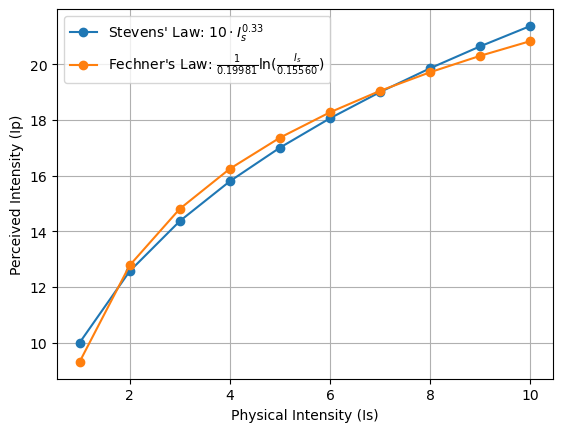

Parameter values for Fechner’s: Ks: 0.00100, I0: 0.01527


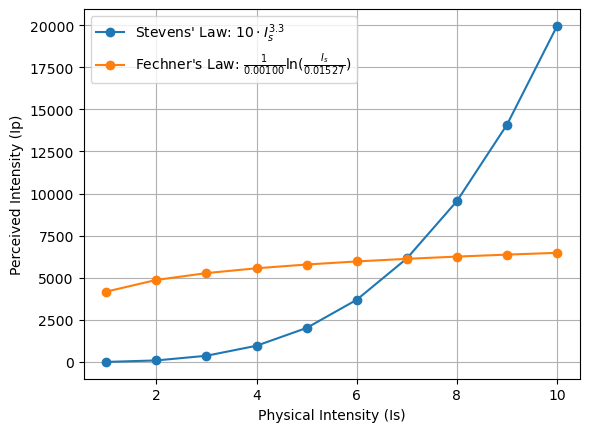

In [125]:
fit_Fechner(Is, 0.33)
fit_Fechner(Is, 3.3)

When a <1, Fechner's Law closely approximates Stevens' Law. However, when a is greater than 1, this is no longer the case. The reason for this is that power laws with an exponent a < 1 can have a shape similar to that of a logarithmic function,  but when the exponent is greater than 1, the two functions diverge significantly in their behavior.